In [1]:
import pandas as pd
import sklearn 
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\lwhieldon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
results = pd.read_pickle('MDHousingDataset.pickle')

# The Categorical Features

Before we begin, let's review the categorical features, remove features not required in our analysis, & convert to dummy variables 

In [3]:
categorical_columns = results.select_dtypes(include='object')
print(categorical_columns.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13136 entries, 249 to 14468
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   LandUseCode                      13136 non-null  object
 1   CountyName                       13136 non-null  object
 2   DwellingType                     13136 non-null  object
 3   TimeofLastDataUpdate             13136 non-null  object
 4   FileRecordType                   13136 non-null  object
 5   CountyCode                       13136 non-null  object
 6   MDPAccountID                     13136 non-null  object
 7   StreetAddress                    13136 non-null  object
 8   BuildingStyleCodeandDescription  13136 non-null  object
 9   CityName                         13136 non-null  object
 10  StreetAddressType                13135 non-null  object
 11  NoofStories                      13136 non-null  object
 12  ZipCode                       

We can safely remove many of categorical features existing in the original dataset since they are either used for processing the data at the source or do not contain relavent information. Let's remove these from our dataset

In [4]:
results = results.drop(columns=[
    'LandUseCode', 
    'CountyName', 
    'TimeofLastDataUpdate', 
    'FileRecordType', 
    'CountyCode',
    'MDPAccountID',
    'StreetAddress',
    'BuildingStyleCodeandDescription',
    'CityName',
    'ZipCode',
    'StreetAddressUnits',
    'CurrentAssessmentYear',
    'NoofUnitsinDwelling',
    'YearBuilt'
])
# We are removed NoofUnitsinDwelling as we are focused only on residential properties, not multiple units (like an apartment)

Now that we reduced our categorical variables to what we need for our model, let's convert these to dummy variables before we start our model

In [5]:
#update Has Basement to 1 & 0 (Binary)
HaseBasementBool = pd.get_dummies(results['HasBasement'])
results['HasBasement']=HaseBasementBool[' With Basement ']

In [6]:
#Added Dummy Variables to NoofStories & DwellingType
NoofStories = pd.get_dummies(results['NoofStories'])
DwellingType = pd.get_dummies(results['DwellingType'])
StreetAddressType = pd.get_dummies(results['StreetAddressType'])
DwellingGrade = pd.get_dummies(results['DwellingGrade'])

In [7]:
#Joined to dummy variables & original continuous variables to new dataframe. Drop data we do not need in the model
processed_results = pd.concat([results, DwellingType ,NoofStories,StreetAddressType,DwellingGrade], axis=1, join='inner')
processed_results = processed_results.drop(['DwellingType','NoofStories','StreetAddressType','DwellingGrade'], axis = 1)
# processed_results.info()
processed_results.columns = ['SizeofHouse','HousingSalesPrice','PriorYearHousingSalesPrice','HasBasement','HouseAge','CenterUnit','EndUnit',
                             'SplitLevel','StandardUnit','1Floor','11/2Floors','2Floors','21/2Floors','3Floors','SingleFamily',
                             'TownHouse','2DwellingGrade','3DwellingGrade','4DwellingGrade','5DwellingGrade',
                             '6DwellingGrade','7DwellingGrade']

processed_results.info(null_counts = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13136 entries, 249 to 14468
Data columns (total 22 columns):
 #   Column                      Dtype
---  ------                      -----
 0   SizeofHouse                 int32
 1   HousingSalesPrice           int32
 2   PriorYearHousingSalesPrice  int32
 3   HasBasement                 uint8
 4   HouseAge                    int32
 5   CenterUnit                  uint8
 6   EndUnit                     uint8
 7   SplitLevel                  uint8
 8   StandardUnit                uint8
 9   1Floor                      uint8
 10  11/2Floors                  uint8
 11  2Floors                     uint8
 12  21/2Floors                  uint8
 13  3Floors                     uint8
 14  SingleFamily                uint8
 15  TownHouse                   uint8
 16  2DwellingGrade              uint8
 17  3DwellingGrade              uint8
 18  4DwellingGrade              uint8
 19  5DwellingGrade              uint8
 20  6DwellingGrade            

# The Numerical features

Now let's look at the numerical features that exist in our dataset

In [8]:
numerical_columns = processed_results.select_dtypes(include=['int64', 'float64','int32'])
print(numerical_columns.info(null_counts = False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13136 entries, 249 to 14468
Data columns (total 4 columns):
 #   Column                      Dtype
---  ------                      -----
 0   SizeofHouse                 int32
 1   HousingSalesPrice           int32
 2   PriorYearHousingSalesPrice  int32
 3   HouseAge                    int32
dtypes: int32(4)
memory usage: 307.9 KB
None


# Correlation of features to target variable
Now let's see how well our features correlate to HousingSalesPrice target variable. 

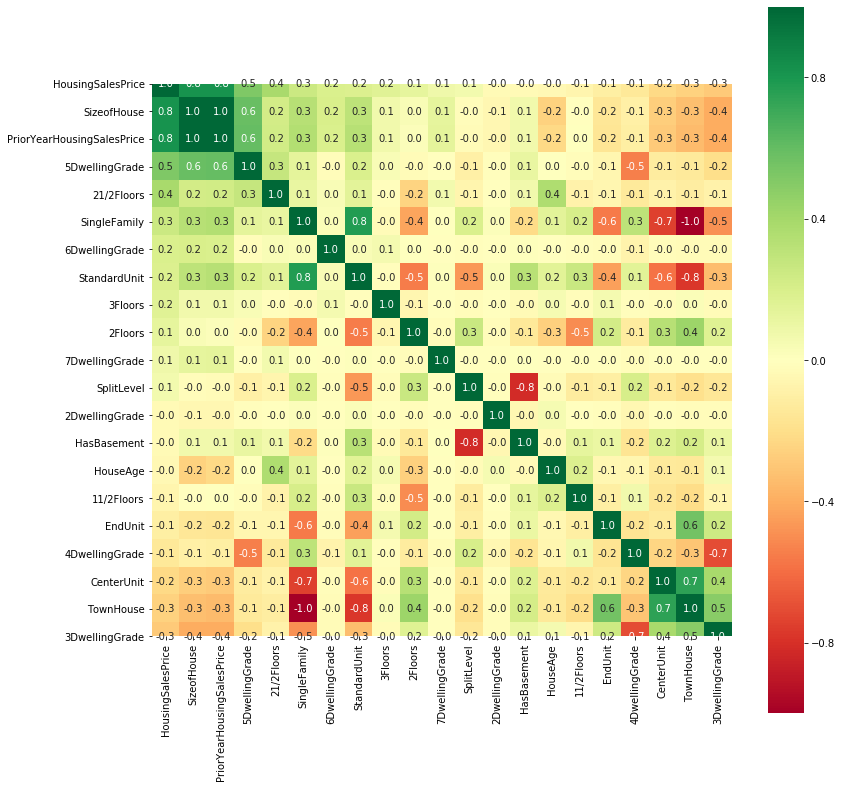

In [9]:
figure, axes = plt.subplots(figsize=(13,13))

correlation_matrix = processed_results.corr()

cols = correlation_matrix.nlargest(21, 'HousingSalesPrice')['HousingSalesPrice'].index
correlation_matrix = np.corrcoef(processed_results[cols].values.T)

heatmap = sns.heatmap(
    correlation_matrix, 
#     cbar=True, 
    annot=True, 
    square=True, 
    cmap=plt.cm.RdYlGn,
    fmt='.1f', 
#     annot_kws={'size': 15}, 
    yticklabels=cols.values, 
    xticklabels=cols.values
)
heatmap.figure.savefig('correlation.png')

Very interesting. Size of House, PriorYearHousingSalesPrice, and 5DwellingGrade have the biggest impact on housing prices. As HouseAge is a numerical feature with a low correlation, I will remove this from our model. 

In [10]:
processed_results = processed_results.drop(columns=['HouseAge'])


# Preprocessing Numerical Features 
Now let's preprocess our numerical features so the values do not have more weight than other features

In [11]:
scaler = preprocessing.StandardScaler()

In [12]:
#applied standard scaling to adjust for houseage, size of house, and housing sales price
processed_results[['SizeofHouse','HousingSalesPrice','PriorYearHousingSalesPrice']]= scaler.fit_transform(processed_results[['SizeofHouse','HousingSalesPrice','PriorYearHousingSalesPrice']]) #add age


# Plotting Correlation of Continuous Features to Target Variable
Let's see how the continuous features (Size of House) relate to HousingSalesPrice 

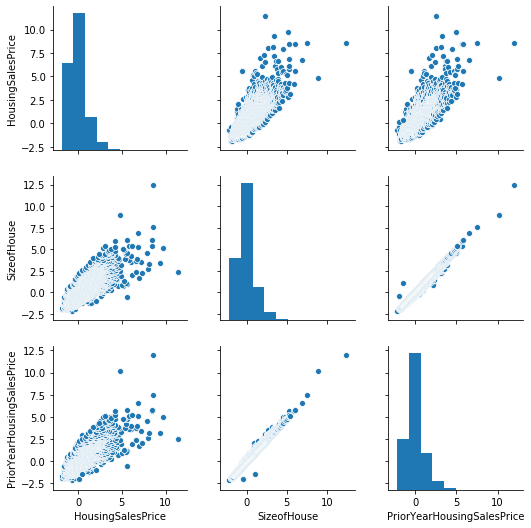

In [13]:
# Plot the Seaborn pairplot
plot = sns.pairplot(processed_results,vars=['HousingSalesPrice','SizeofHouse','PriorYearHousingSalesPrice'])



There's definitely a positive correlation between housing sales price, size of house and prior year housing sales price. Interestingly Size of House and PriorYearHousingSalesPrice have some extreme outliers, so I will remove them from the model

In [14]:
q_low = processed_results["SizeofHouse"].quantile(0.05)
q_hi  = processed_results["SizeofHouse"].quantile(0.94)

processed_results = processed_results[(processed_results["SizeofHouse"] < q_hi) & (processed_results["SizeofHouse"] > q_low)]

In [15]:
q_low = processed_results["PriorYearHousingSalesPrice"].quantile(0.05)
q_hi  = processed_results["PriorYearHousingSalesPrice"].quantile(0.94)

processed_results = processed_results[(processed_results["PriorYearHousingSalesPrice"] < q_hi) & (processed_results["PriorYearHousingSalesPrice"] > q_low)]

In [16]:
processed_results.reset_index()

,index,SizeofHouse,HousingSalesPrice,PriorYearHousingSalesPrice,HasBasement,CenterUnit,EndUnit,SplitLevel,StandardUnit,1Floor,...,21/2Floors,3Floors,SingleFamily,TownHouse,2DwellingGrade,3DwellingGrade,4DwellingGrade,5DwellingGrade,6DwellingGrade,7DwellingGrade
0,974,-1.160412,0.234214,-0.922413,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
1,1026,-1.148304,0.186142,-0.926751,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,1050,-1.142881,-0.429493,-0.986014,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1067,-1.138098,-0.885403,-1.008353,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1080,-1.134588,-0.767549,-1.014562,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10396,13143,1.296082,1.273194,1.155734,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
10397,13147,1.298311,0.559864,1.188005,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
10398,13154,1.308516,0.913428,1.167835,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
10399,13185,1.343905,1.257687,1.202274,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


Now let's replot after we have removed outliers

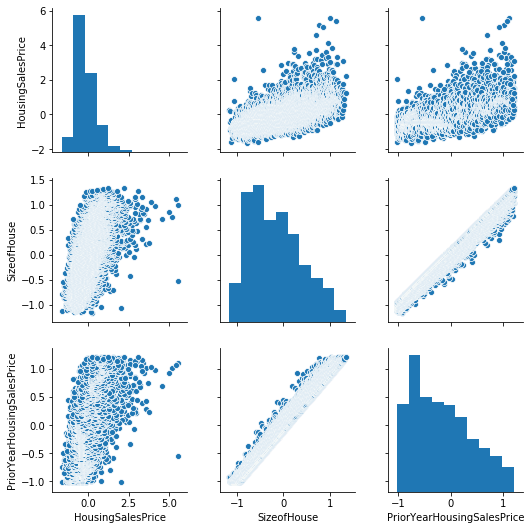

In [17]:
# Plot the Seaborn pairplot
plot = sns.pairplot(processed_results,vars=['HousingSalesPrice','SizeofHouse','PriorYearHousingSalesPrice'])
plot.savefig('pairplot.png')


Nice. There's still a positive correlation between house sales price and size of house but now the outliers are removed and will not affect our model.

Now that we've removed the outliers to SizeofHouse, there are no more residential properties where 7DwellingGrade = 1; we can remove this column from our dataset.

In [18]:
processed_results['7DwellingGrade'].unique()

array([0], dtype=uint8)

In [19]:
processed_results = processed_results.drop(columns=['7DwellingGrade'])

# Demonstrating Correlation of Categorical Features to Target Variable
To add an additional demonstration of the correlation between the categorical dummy variables and the target variable, housing sales price, I also want to use Point Biserial Correlation using scipy.stats.pointbiserialr's function. 
This is a great way to measure the relationship between a binary variable (in this case, our dummy variables) and a continuous variable (housing sales price). Return values that are closer to -1 or +1 imply high correlation.

In [22]:
from scipy import stats

HouseSalesPrice = processed_results['HousingSalesPrice']
HasBasement = processed_results['HasBasement']
CenterUnit = processed_results['CenterUnit']
EndUnit = processed_results['EndUnit']
SplitLevel = processed_results['SplitLevel']
StandardUnit = processed_results['StandardUnit']
OneFloor = processed_results['1Floor']
OneHalfFloors = processed_results['11/2Floors']
TwoFloors = processed_results['2Floors']
TwoHalfFloors = processed_results['21/2Floors']
ThreeFloors = processed_results['3Floors']
SingleFamily = processed_results['SingleFamily']
TownHouse = processed_results['TownHouse']
TwoDwellingGrade = processed_results['2DwellingGrade']
ThreeDwellingGrade = processed_results['3DwellingGrade']
FourDwellingGrade = processed_results['4DwellingGrade']
FiveDwellingGrade = processed_results['5DwellingGrade']
SixDwellingGrade = processed_results['6DwellingGrade']

print("Point Biserial Correlation for Categorical Features:\n")
print("HasBasement: {}".format(stats.pointbiserialr(HouseSalesPrice, HasBasement)))
print("CenterUnit: {}".format(stats.pointbiserialr(HouseSalesPrice, CenterUnit))) 
print("EndUnit: {}".format(stats.pointbiserialr(HouseSalesPrice, EndUnit))) 
print("SplitLevel: {}".format(stats.pointbiserialr(HouseSalesPrice, SplitLevel))) 
print("OneFloor: {}".format(stats.pointbiserialr(HouseSalesPrice, OneFloor))) 
print("OneHalfFloors: {}".format(stats.pointbiserialr(HouseSalesPrice, OneHalfFloors))) 
print("TwoFloors: {}".format(stats.pointbiserialr(HouseSalesPrice, TwoFloors))) 
print("TwoHalfFloors: {}".format(stats.pointbiserialr(HouseSalesPrice, TwoHalfFloors))) 
print("ThreeFloors: {}".format(stats.pointbiserialr(HouseSalesPrice, ThreeFloors))) 
print("SingleFamily: {}".format(stats.pointbiserialr(HouseSalesPrice, SingleFamily))) 
print("TownHouse: {}".format(stats.pointbiserialr(HouseSalesPrice, TownHouse))) 
print("TwoDwellingGrade: {}".format(stats.pointbiserialr(HouseSalesPrice, TwoDwellingGrade))) 
print("ThreeDwellingGrade: {}".format(stats.pointbiserialr(HouseSalesPrice, ThreeDwellingGrade))) 
print("FourDwellingGrade: {}".format(stats.pointbiserialr(HouseSalesPrice, FourDwellingGrade))) 
print("FiveDwellingGrade: {}".format(stats.pointbiserialr(HouseSalesPrice, FiveDwellingGrade))) 
print("SixDwellingGrade: {}".format(stats.pointbiserialr(HouseSalesPrice, SixDwellingGrade))) 

Point Biserial Correlation for Categorical Features:

HasBasement: PointbiserialrResult(correlation=-0.1890392268049824, pvalue=2.7734482519581116e-84)
CenterUnit: PointbiserialrResult(correlation=-0.17999913540021634, pvalue=1.8334711698287518e-76)
EndUnit: PointbiserialrResult(correlation=-0.0914077681593651, pvalue=9.571125689768914e-21)
SplitLevel: PointbiserialrResult(correlation=0.17879076864861218, pvalue=1.8955797622494059e-75)
OneFloor: PointbiserialrResult(correlation=-0.3637217674014366, pvalue=8e-323)
OneHalfFloors: PointbiserialrResult(correlation=-0.07643871702010847, pvalue=5.898004181636372e-15)
TwoFloors: PointbiserialrResult(correlation=0.24006795193071262, pvalue=2.955137993563317e-136)
TwoHalfFloors: PointbiserialrResult(correlation=0.3757536073434737, pvalue=0.0)
ThreeFloors: PointbiserialrResult(correlation=0.07812079183122062, pvalue=1.4823162460901786e-15)
SingleFamily: PointbiserialrResult(correlation=0.2080230395466467, pvalue=4.790576023072144e-102)
TownHouse

Very interesting. The dummy variables with the most impact (30% or greater correlation) include: `'PriorYearHousingSalesPrice'`, `'OneFloor'`,  `'TwoDwellingGrade'`. 

Let's keep all variables in the model for now to see how our accuracy score reflects the models.

# Saving Updated Data

Now that we have our data transformed and performed a thorough examination of the features, let's go ahead and save the data off to a pickle for adding to our model

In [21]:
processed_results.to_pickle('MDHousingDataset_PreProcessed.pickle')